In [2]:
import matplotlib.pyplot as plt
import numpy as np

## ガウス過程回帰の一般化

### ロバストなガウス過程回帰

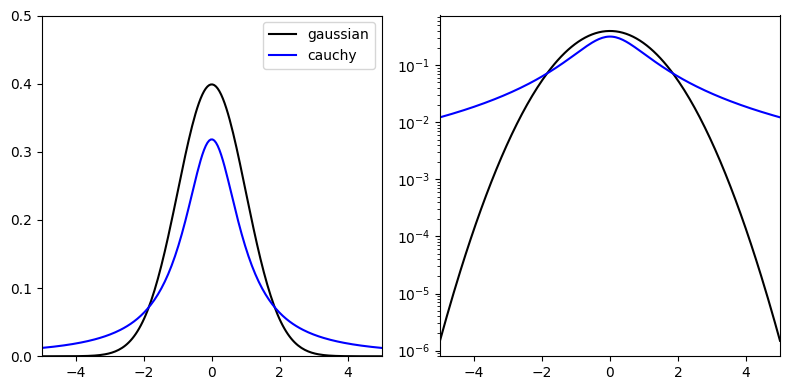

In [ ]:
# \gamma = 1 のcauchy分布
xx = np.linspace(-5, 5, 200)
yy_cauchy = 1/(np.pi*(1.0+(xx**2))) # 中心0、\gamma=1 のcauchy分布
yy_gauss = 1/np.sqrt(2*np.pi)*np.exp(-(xx**2)/2) #標準正規分布

fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].plot(xx, yy_gauss, color="black", label="gaussian")
ax[0].plot(xx, yy_cauchy, color="blue", label="cauchy")
ax[1].plot(xx, yy_gauss, color="black", label="gaussian")
ax[1].plot(xx, yy_cauchy, color="blue", label="cauchy")
ax[0].set_xlim(-5,5)
ax[0].set_ylim(0,0.5)
ax[0].legend()
ax[1].set_xlim(-5,5)
ax[1].set_yscale("log")
fig.tight_layout()

In [ ]:
# 楕円スライスサンプリングの実装 (http://chasen.org/~daiti-m/gpbook/python/elliptical.py)
# 入力: N(0, K) に従う現在のガウス過程 f (prior) と尤度関数 L (likfun)
# 出力: 新しくサンプルされた f (posterior)

#  xx     : Dx1 initial vector
#  prior  : DxD matrix from chol(L)
#  likfun : function of likelihood evaluation
#  params : parameters passed to likfun (optional)
#  curlik : current likelihood (possibly from previous iteration)
#  angle  : default 0 ((0,2*pi])

def elliptical(xx, prior, likfun, params, curlik = None, angle_range=0):
    rng = np.random.default_rng()
    D = len(xx)
    if curlik is None: # 現在の尤度の計算
        curlik = likfun(xx, params)
    nu = prior @ rng.normal(size=(1, D)).T # nuのサンプリング
    hh = np.log(rng.random()) + curlik # 尤度の閾値
    if angle_range <= 0:
        phi = rng.random()*2*np.pi # phiを一様分布からサンプリング
        min_phi = phi - 2*np.pi
        max_phi = phi
    else: # 現在の点を中心にランダムに探索区間を設定
        min_phi = - angle_range*rng.random()
        max_phi = min_phi + angle_range
        phi = min_phi + rng.random()*(max_phi - min_phi) # phiを一様分布からサンプリング
    while True:
        prop = xx*np.cos(phi) + nu*np.sin(phi)
        curlik = likfun(prop, params)
        if curlik > hh: # 尤度が閾値を超える(スライスより上にある)場合、prop を受理
            break
        else:
            if phi > 0:
                max_phi = phi
            elif phi < 0:
                min_phi = phi
            else:
                raise IOError('BUG: slice sampling shrunk to the current position.')
        phi = min_phi + rng.random()*(max_phi-min_phi) # phiを一様分布からサンプル
    return prop, curlik

In [157]:
class MyGPR_cauchy:
    def __init__(self, xtrain, ytrain, xx, kernel: str, params_gauss: list = None, gamma=1.0, iters=10) -> None:
        self.xtrain = xtrain
        self.len_xt = len(self.xtrain)
        self.ytrain = ytrain
        self.xx = xx
        self.xx_all = np.vstack([self.xtrain, self.xx])
        self.len_xx_all = len(self.xx_all)
        self.kernel_name = kernel
        self.params_gauss = params_gauss
        self.gamma = gamma
        self.iters = iters
        self.g_list = []
        if self.kernel_name == 'rbf':
            self.kernel_func = self.kgauss()

    def kgauss(self):
        if self.params_gauss is None:
            tau, sigma = 0.0, 0.0
        else:
            tau, sigma = self.params_gauss
        return lambda x1, x2: np.exp(tau) * np.exp(- np.sum((x1 - x2) ** 2, axis=0) / np.exp(sigma))
    
    def kernel_matrix(self, xx, epsilon=1e-6):
        n = xx.shape[0]
        K = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                K[i, j] = self.kernel_func(xx[i], xx[j])
        K_stable = K + epsilon * np.eye(K.shape[0])
        return K_stable
    
    def gpr_cauchy(self, f, K_inv):
        return self.gpr_cauchy_lik(f[:self.len_xt], K_inv)
    
    def gpr_cauchy_lik(self, f, K_inv):
        sumlik_cauchy = 0
        for i in range(self.len_xt):
            sumlik_cauchy += - np.log(self.gamma + (self.ytrain[i,0]-f[i,0])**2/self.gamma)
        return sumlik_cauchy - (f.T @ K_inv @ f)[0,0]
    
    def gpr_mcmc(self):
        rng = np.random.default_rng()
        K = self.kernel_matrix(self.xx_all)
        K_inv = np.linalg.inv(K[:self.len_xt, :self.len_xt])
        L = np.linalg.cholesky(K)
        f = L @ rng.normal(size=(1, self.len_xx_all)).T
        # g = np.zeros(self.len_xx_all)
        for i in range(self.iters):
            f, lik = self.elliptical(f, L, K_inv)
            # g = g + f.T[0]
            # self.g_list.append(g)
            self.g_list.append(f.T[0])
            if (i+1) % 10 == 0:
                print(f'[iter {i+1}]')
        return None
    
    def plot_gpr_mcmc(self):
        g_sum = np.zeros(self.len_xx_all - self.len_xt)
        colors = plt.cm.rainbow(np.linspace(0, 1, self.iters))
        fig, ax = plt.subplots()
        g_sum = np.zeros(self.len_xx_all - self.len_xt)
        for i in range(self.iters):
            ax.plot(self.xx, self.g_list[i][self.len_xt:], color=colors[i], linewidth = 1, zorder=0)
            g_sum += self.g_list[i][self.len_xt:]
        ax.plot(self.xx, g_sum/self.iters, color='black', linewidth = 3, zorder=1)
        ax.scatter(self.xtrain, self.ytrain, marker='x', color='black', label='Train', zorder=2)

    def elliptical(self, f, prior, K_inv, curlik = None, angle_range=0):
        rng = np.random.default_rng()
        if curlik is None: # 現在の尤度の計算
            curlik = self.gpr_cauchy(f, K_inv)
        nu = prior @ rng.normal(size=(1, self.len_xx_all)).T # nuのサンプリング
        hh = np.log(rng.random()) + curlik # 尤度の閾値
        if angle_range <= 0:
            phi = rng.random()*2*np.pi # phiを一様分布からサンプリング
            min_phi = phi - 2*np.pi
            max_phi = phi
        else: # 現在の点を中心にランダムに探索区間を設定
            min_phi = - angle_range*rng.random()
            max_phi = min_phi + angle_range
            phi = min_phi + rng.random()*(max_phi - min_phi) # phiを一様分布からサンプリング
        while True:
            prop = f*np.cos(phi) + nu*np.sin(phi)
            curlik = self.gpr_cauchy(prop, K_inv)
            if curlik > hh: # 尤度が閾値を超える(スライスより上にある)場合、prop を受理
                break
            else:
                if phi > 0:
                    max_phi = phi
                elif phi < 0:
                    min_phi = phi
                else:
                    raise IOError('BUG: slice sampling shrunk to the current position.')
            phi = min_phi + rng.random()*(max_phi-min_phi) # phiを一様分布からサンプル
        return prop, curlik
    

In [158]:
data = np.loadtxt('./../data/chap3/gpr-cauchy.dat')
xtrain, ytrain = data[:, 0].reshape(-1, 1), data[:, 1].reshape(-1, 1)
xx = np.linspace(-5, 5, 100).reshape(-1, 1)

[iter 10]
[iter 20]
[iter 30]
[iter 40]
[iter 50]
[iter 60]
[iter 70]
[iter 80]
[iter 90]
[iter 100]


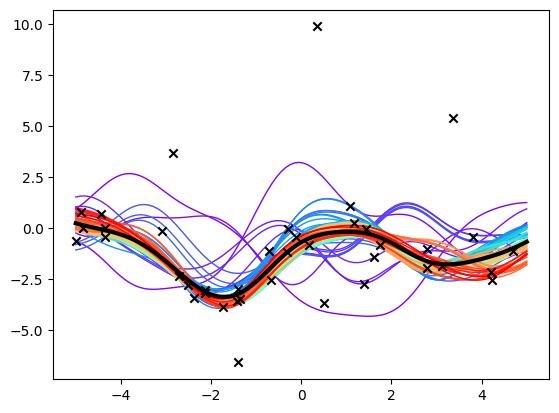

In [159]:
params_gauss = np.array([1.0, 1.0])
gamma = 0.2
gpr_cauchy = MyGPR_cauchy(xtrain, ytrain, xx, "rbf", params_gauss, gamma, iters=100)
gpr_cauchy.gpr_mcmc()
gpr_cauchy.plot_gpr_mcmc()

### ガウス過程識別モデル